In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sessions.csv', 'test_users.csv', 'age_gender_bkts.csv', 'countries.csv', 'sample_submission.csv', 'sample_submission_NDF.csv', 'train_users_2.csv']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('../input/train_users_2.csv', parse_dates=['timestamp_first_active','date_account_created',
                                                               'date_first_booking'])
test = pd.read_csv('../input/test_users.csv',parse_dates=['timestamp_first_active','date_account_created',
                                                          'date_first_booking'])

train_X = train.drop(['country_destination'], axis=1)
train_y = train['country_destination']

train_X.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [4]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,2014-07-01 00:00:06,NaT,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,2014-07-01 00:00:51,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,2014-07-01 00:01:48,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,2014-07-01 00:02:15,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,2014-07-01 00:03:05,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [5]:
data = pd.concat((train_X, test), axis=0, ignore_index=True)
#display(data.shape)
total_shape = ((train_X.shape[0] + test.shape[0]), train_X.shape[1])
assert data.shape == total_shape
display(data.head())

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


## Data Exploration

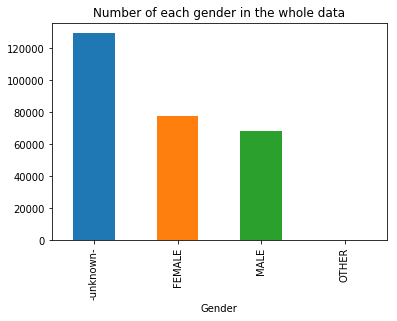

In [6]:
data.gender.value_counts(dropna=False).plot(kind='bar')
plt.title('Number of each gender in the whole data')
plt.xlabel('Gender')
plt.show()

> Report: So there are a lot of unknown values for the gender

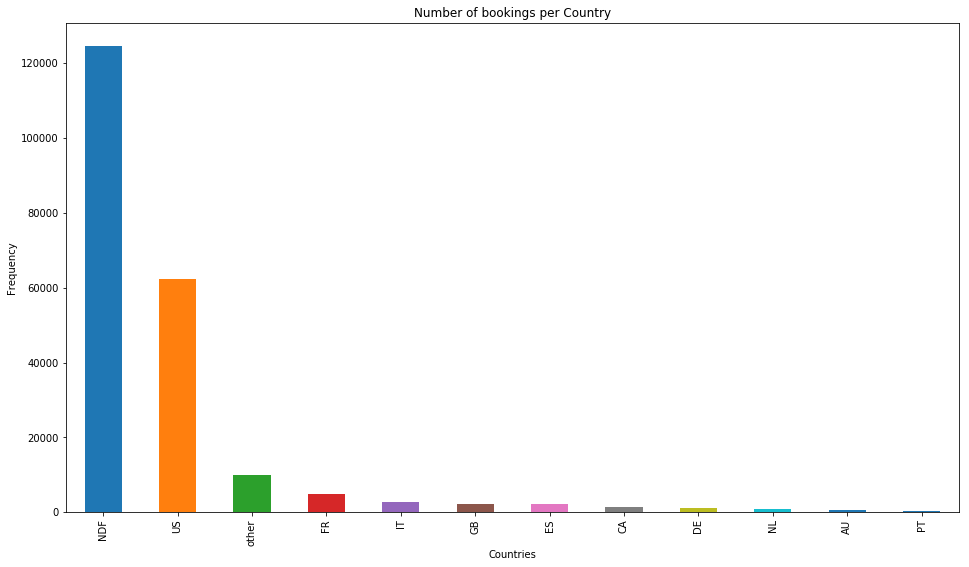

In [7]:
plt.figure(figsize=(16, 9))
train_y.value_counts().plot(kind='bar')
plt.title('Number of bookings per Country')
plt.xlabel('Countries')
plt.ylabel('Frequency')
plt.show()

In [8]:
def missing_df(df):
    missing_df = pd.DataFrame({'%missing': df.isnull().sum()/df.shape[0]*100,
                              '#missing': df.isnull().sum()})
    return missing_df

In [9]:
data_missing = missing_df(data).sort_values(by='%missing', ascending=False)
train_missing = missing_df(train_X).sort_values(by='%missing', ascending=False)
test_missing = missing_df(test).sort_values(by='%missing', ascending=False)

In [10]:
print("{}    Whole Data    {}".format('*'*10, '*'*10))
display(data_missing)
print("{}    Train Data    {}".format('*'*10, '*'*10))
display(train_missing)
print("{}    Test Data    {}".format('*'*10, '*'*10))
display(test_missing)

**********    Whole Data    **********


,%missing,#missing
date_first_booking,67.733998,186639
age,42.412365,116866
first_affiliate_tracked,2.208335,6085
id,0.000000,0
date_account_created,0.000000,0
timestamp_first_active,0.000000,0
gender,0.000000,0
signup_method,0.000000,0
signup_flow,0.000000,0
language,0.000000,0


**********    Train Data    **********


,%missing,#missing
date_first_booking,58.347349,124543
age,41.222576,87990
first_affiliate_tracked,2.841402,6065
id,0.000000,0
date_account_created,0.000000,0
timestamp_first_active,0.000000,0
gender,0.000000,0
signup_method,0.000000,0
signup_flow,0.000000,0
language,0.000000,0


**********    Test Data    **********


,%missing,#missing
date_first_booking,100.000000,62096
age,46.502190,28876
first_affiliate_tracked,0.032208,20
id,0.000000,0
date_account_created,0.000000,0
timestamp_first_active,0.000000,0
gender,0.000000,0
signup_method,0.000000,0
signup_flow,0.000000,0
language,0.000000,0


In [11]:
data.gender.replace('-unknown-', np.nan, inplace=True)
data.first_browser.replace('-unknown-', np.nan,inplace=True)

Text(0.5, 0, 'Age')

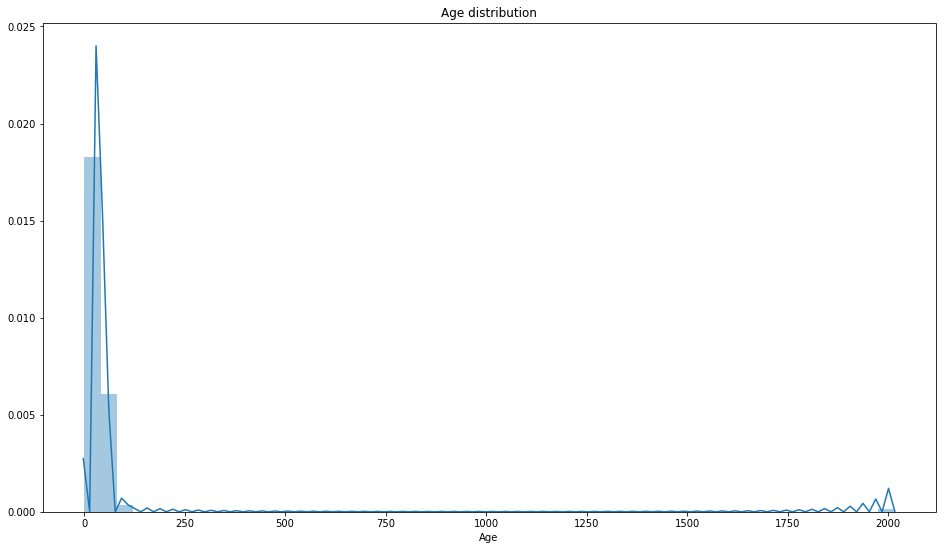

In [12]:
plt.figure(figsize=(16,9))
sns.distplot(data.age.dropna())
plt.title('Age distribution')
plt.xlabel('Age')

In [13]:
# Removing age outliers
data.loc[data.age < 18] = np.nan
data.loc[data.age > 120] = np.nan

Text(0.5, 0, 'Age')

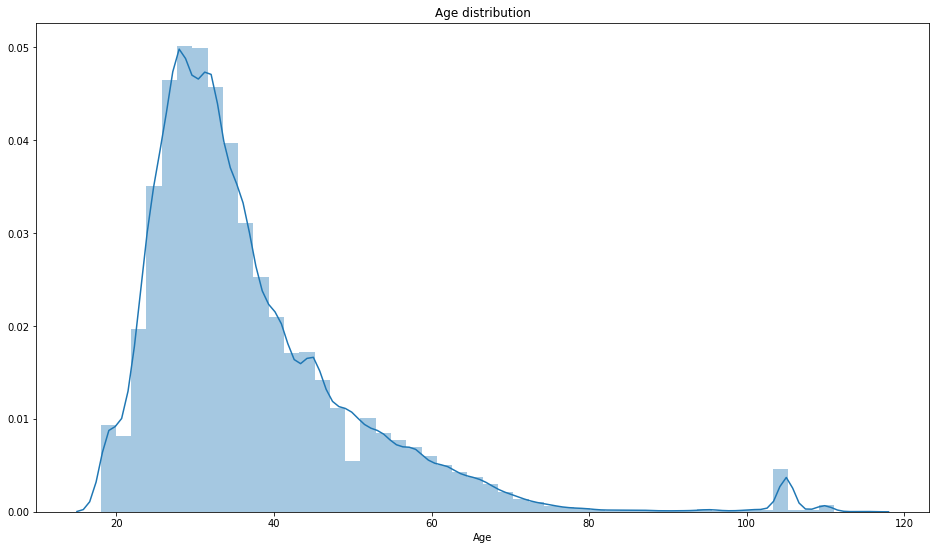

In [14]:
plt.figure(figsize=(16,9))
sns.distplot(data.age.dropna())
plt.title('Age distribution')
plt.xlabel('Age')

In [15]:
data.age.describe()

count    157663.000000
mean         36.891972
std          13.810232
min          18.000000
25%          28.000000
50%          33.000000
75%          42.000000
max         115.000000
Name: age, dtype: float64

That looks preety good as the mean and median are 36 and 33 which says the young people tend to go for holidays more.

## Feature Extraction

In [16]:
# creating the date time data from date account created
data['dac_year'] = data.date_account_created.dt.year
data['dac_month'] = data.date_account_created.dt.month
data['dac_month'] = data.date_account_created.dt.date

# creating time first active data
data['tfa_year'] = data.timestamp_first_active.dt.year
data['tfa_month'] = data.timestamp_first_active.dt.month
data['tfa_day'] = data.timestamp_first_active.dt.day

data.drop(['date_account_created', 'timestamp_first_active'], axis=1, inplace=True)

In [17]:
display(data.head())
display(data.shape)

,id,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,tfa_year,tfa_month,tfa_day
0,gxn3p5htnn,NaT,NaN,NaN,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010.0,2010-06-28,2009.0,3.0,19.0
1,820tgsjxq7,NaT,MALE,38.0,facebook,0.0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011.0,2011-05-25,2009.0,5.0,23.0
2,4ft3gnwmtx,2010-08-02,FEMALE,56.0,basic,3.0,en,direct,direct,untracked,Web,Windows Desktop,IE,2010.0,2010-09-28,2009.0,6.0,9.0
3,bjjt8pjhuk,2012-09-08,FEMALE,42.0,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011.0,2011-12-05,2009.0,10.0,31.0
4,87mebub9p4,2010-02-18,NaN,41.0,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010.0,2010-09-14,2009.0,12.0,8.0


(275547, 18)

## Data Analysis

In [18]:
data.describe()

,age,signup_flow,dac_year,tfa_year,tfa_month,tfa_day
count,157663.000000,274529.000000,274529.000000,274529.000000,274529.000000,274529.000000
mean,36.891972,4.296916,2013.245974,2013.245486,6.458443,15.958686
std,13.810232,8.799980,0.919665,0.920219,2.984635,8.757388
min,18.000000,0.000000,2010.000000,2009.000000,1.000000,1.000000
25%,28.000000,0.000000,2013.000000,2013.000000,4.000000,8.000000
50%,33.000000,0.000000,2014.000000,2014.000000,7.000000,16.000000
75%,42.000000,1.000000,2014.000000,2014.000000,9.000000,24.000000
max,115.000000,25.000000,2014.000000,2014.000000,12.000000,31.000000


In [19]:
data.groupby('gender').age.agg(['min', 'max', 'mean', 'count'])

,min,max,mean,count
gender,,,,
FEMALE,18.0,115.0,36.313890,71318
MALE,18.0,115.0,36.862420,63919
OTHER,18.0,78.0,35.945455,275


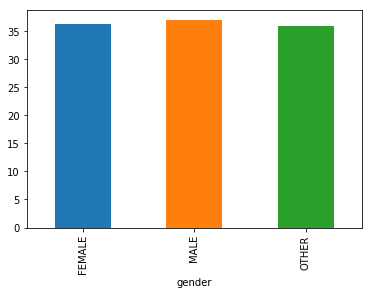

In [20]:
data.groupby('gender').age.mean().plot(kind='bar')

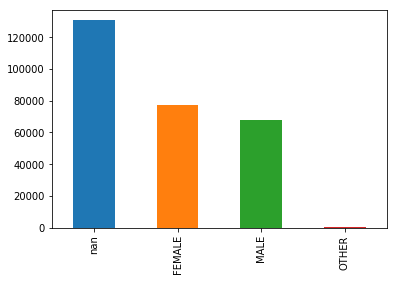

In [21]:
data.gender.value_counts(dropna=False).plot(kind='bar')

Text(0.5, 1.0, 'Number of accounts created by year')

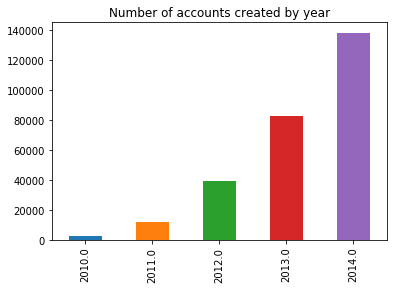

In [22]:
data.dac_year.value_counts(sort=False).plot(kind='bar')
plt.title('Number of accounts created by year')

Text(0.5, 1.0, 'Number of users by first active year')

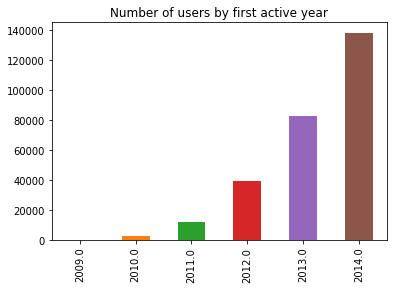

In [23]:
data.tfa_year.value_counts(sort=False).plot(kind='bar')
plt.title('Number of users by first active year')

In [24]:
data.language.value_counts(sort=True)


en           264594
zh             2630
fr             1484
es             1165
ko             1109
de              973
it              629
ru              498
ja              345
pt              319
sv              176
nl              133
tr               92
da               75
pl               71
no               51
cs               47
el               30
th               27
hu               24
id               23
fi               20
ca                6
is                5
hr                2
-unknown-         1
Name: language, dtype: int64

## Data Preprocessing

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 18 columns):
id                         274529 non-null object
date_first_booking         88510 non-null datetime64[ns]
gender                     145135 non-null object
age                        157663 non-null float64
signup_method              274529 non-null object
signup_flow                274529 non-null float64
language                   274529 non-null object
affiliate_channel          274529 non-null object
affiliate_provider         274529 non-null object
first_affiliate_tracked    268500 non-null object
signup_app                 274529 non-null object
first_device_type          274529 non-null object
first_browser              230296 non-null object
dac_year                   274529 non-null float64
dac_month                  274529 non-null object
tfa_year                   274529 non-null float64
tfa_month                  274529 non-null float64
tfa_day                    

In [26]:
data.drop('id', axis=1, inplace=True)

In [27]:
data.signup_flow = data.signup_flow.astype('str', inplace=True)

In [28]:
cat_features = []
for col in data.columns:
    if data[col].dtype == 'object':
        cat_features.append(col)
        
cat_features

['gender',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'dac_month']

In [29]:
cat_features.remove('dac_month')

In [30]:
data.drop('date_first_booking', axis=1, inplace=True)

In [31]:
data = pd.get_dummies(data, columns=cat_features)
data.head()

,age,dac_year,dac_month,tfa_year,tfa_month,tfa_day,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,signup_flow_0.0,signup_flow_1.0,signup_flow_10.0,signup_flow_12.0,signup_flow_14.0,signup_flow_15.0,signup_flow_16.0,signup_flow_2.0,signup_flow_20.0,signup_flow_21.0,signup_flow_23.0,signup_flow_24.0,signup_flow_25.0,signup_flow_3.0,signup_flow_4.0,signup_flow_5.0,signup_flow_6.0,signup_flow_8.0,signup_flow_nan,language_-unknown-,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,...,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IBrowse,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Nintendo Browser,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,NaN,2010.0,2010-06-28,2009.0,3.0,19.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,2011.0,2011-05-25,2009.0,5.0,23.0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,56.0,2010.0,2010-09-28,2009.0,6.0,9.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,42.0,2011.0,2011-12-05,2009.0,10.0,31.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,41.0,2010.0,2010-09-14,2009.0,12.0,8.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
data.shape

(275547, 158)

In [33]:
data.drop('dac_month', axis=1, inplace=True)

In [34]:
data = data.fillna(-1)
data.head()

,age,dac_year,tfa_year,tfa_month,tfa_day,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,signup_flow_0.0,signup_flow_1.0,signup_flow_10.0,signup_flow_12.0,signup_flow_14.0,signup_flow_15.0,signup_flow_16.0,signup_flow_2.0,signup_flow_20.0,signup_flow_21.0,signup_flow_23.0,signup_flow_24.0,signup_flow_25.0,signup_flow_3.0,signup_flow_4.0,signup_flow_5.0,signup_flow_6.0,signup_flow_8.0,signup_flow_nan,language_-unknown-,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,...,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IBrowse,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Nintendo Browser,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,-1.0,2010.0,2009.0,3.0,19.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,2011.0,2009.0,5.0,23.0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,56.0,2010.0,2009.0,6.0,9.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,42.0,2011.0,2009.0,10.0,31.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,41.0,2010.0,2009.0,12.0,8.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
data_matrix = data.values
X_train = data_matrix[:train_X.shape[0]]
len(X_train)

213451

In [36]:
X_test = data_matrix[train_X.shape[0]:]
len(X_test)

62096

In [37]:
def dcg_at_k(r, k, method=1):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k=5, method=1):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def score_predictions(preds, truth, n_modes=5):
    """
    preds: pd.DataFrame
      one row for each observation, one column for each prediction.
      Columns are sorted from left to right descending in order of likelihood.
    truth: pd.Series
      one row for each obeservation.
    """
    assert(len(preds)==len(truth))

    r = pd.DataFrame(0, index=preds.index, columns=preds.columns, dtype=np.float64)
    for col in preds.columns:
        r[col] = (preds[col] == truth) * 1.0

    score = pd.Series(r.apply(ndcg_at_k, axis=1, reduce=True), name='score')
    return score.mean()

In [38]:
"""Metrics to compute the model performance."""
# ref: https://www.kaggle.com/davidgasquez/airbnb-recruiting-new-user-bookings/ndcg-scorer
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.
        
    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    #lb.fit(range(len(predictions) + 1))  ## original
    #lb.fit(range(predictions.shape[1] + 1))
    #T = lb.transform(ground_truth)
    
    T = lb.fit_transform(ground_truth) 

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [39]:
labels = train_y.values
labeler = LabelEncoder()
y_train = labeler.fit_transform(labels)

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(n_estimators=100, random_state=42)
parameters = {'min_samples_split': [2, 20],
              'max_depth': [6, 8, 10]
             }

reg = GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)

reg.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 20], 'max_depth': [6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(ndcg_score, needs_proba=True, k=5), verbose=0)

In [41]:
from sklearn.model_selection import learning_curve
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring=ndcg_scorer,
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))


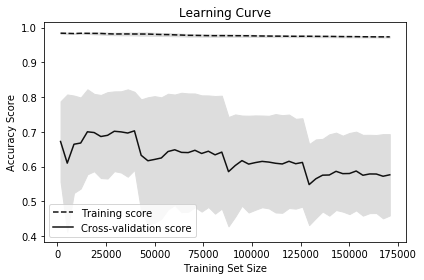

In [42]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [43]:
y_pred = reg.predict_proba(X_train)

truth = pd.Series(labeler.inverse_transform(y_train))
preds = []

for i in range(len(X_train)):
    preds += [labeler.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()]

preds = pd.DataFrame(preds)
print("Score for Random Forrest: " + str(score_predictions(preds, truth)))

Score for Random Forrest: 0.8084947391581118


In [44]:
# make predictions on test set
ypred = reg.predict_proba(X_test)
id_test = test['id']
# Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += labeler.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('random_forrest.csv',index=False)